In [65]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import glob
import utils
import matplotlib.colors as colors
import cmaps
from statsmodels.nonparametric.smoothers_lowess import lowess as  sm_lowess
from scipy.stats import pearsonr, t as tdist
from scipy.stats import t

In [66]:
def pvalue_array(x,y,dname):
    x_an=x-x.mean(dname)
    y_an=y-y.mean(dname)
    slope=(x_an*y_an).sum(dname)/(x_an*x_an).sum(dname)
    interc=y.mean(dname)-slope*x.mean(dname)
    ypred=slope*x+interc
    n=len(x[dname])
    mse=np.sqrt(((y-ypred)**2).sum(dname)/(n-2))
    xsq=np.sqrt(((x_an)**2).sum(dname))
    standerr=mse/xsq
    pval=2*(1-t.cdf(np.abs(slope/standerr),n-2))
    pval=xr.DataArray(pval,dims=standerr.dims,coords=standerr.coords)
    return pval

def rvalue_array(x,y,dname):
    xmean=x.mean(dname)
    ymean=y.mean(dname)
    numer=(x*y).mean(dname)-xmean*ymean
    denom=np.sqrt(((x**2).mean(dname)-xmean**2)*(((y**2).mean(dname))-(ymean**2)))
    return numer/denom

def regcoeff_array(x,y,dname):
    x_an=x-x.mean(dname)
    y_an=y-y.mean(dname)
    slope=(x_an*y_an).sum(dname)/(x_an*x_an).sum(dname)
    return slope

def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg, skipna=True)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

def trend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg, skipna=True)
    return p

def ann_mean(var):
    month_length = var.time.dt.days_in_month
    wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()
    var_ann = (var*wgts).groupby("time.year").sum()
    return var_ann

In [67]:
datadir='/Projects/RAPrototype/ERA5'
plotdir='/home/ghervieux/SCRIPTS/GEV/PLOTS'

In [68]:
state_borders =\
cartopy.feature.NaturalEarthFeature(category='cultural',\
        name='admin_1_states_provinces_lakes', scale='50m', facecolor='none')

In [69]:
lon_min = 190
lon_max = 310 
lat_min =  19
lat_max =  75 

In [70]:
yearb = 1941
yeari = 1976
yeare = 2023

In [71]:
ifile = f'/Projects/era5/Monthlies/monolevel/air.2m.mon.mean.nc' 
dsair = xr.open_dataset(ifile)
dsair = dsair.sortby('lat')
dsair = dsair.sel(lon=slice(lon_min,lon_max),lat=slice(lat_min,lat_max))
time = dsair['time']
air = dsair['air']

ann_air = ann_mean(air)
ann_air = ann_air.sel(year=slice(yearb,yeare))
units='$\degree$K'

<>:10: SyntaxWarning: invalid escape sequence '\d'
<>:10: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_483484/2150561705.py:10: SyntaxWarning: invalid escape sequence '\d'
  units='$\degree$K'


In [72]:
time_b = ann_air.year.sel(year=slice(f'{yearb}',f'{yeari}'))
time_a = ann_air.year.sel(year=slice(f'{yeari}',f'{yeare}'))

In [73]:
trend_b = trend_dim(ann_air.sel(year=time_b),'year')
trend_a = trend_dim(ann_air.sel(year=time_a),'year')

deg0_b = trend_b['polyfit_coefficients'].sel(degree=0)
deg1_b = trend_b['polyfit_coefficients'].sel(degree=1) 
deg0_a = trend_a['polyfit_coefficients'].sel(degree=0)
deg1_a = trend_a['polyfit_coefficients'].sel(degree=1)

jump = (deg1_a * time_a[0].data + deg0_a) - (deg1_b * time_b[-1].data + deg0_b)

In [74]:
ptlon = [211.25  ,220.,291.5,222]
ptlat = [ 60.5, 63.75, 70.25, 59.5   ]

Text(0.5, 1.0, '1976 Jump from linear regression \n for Annual Temperature at 2m')

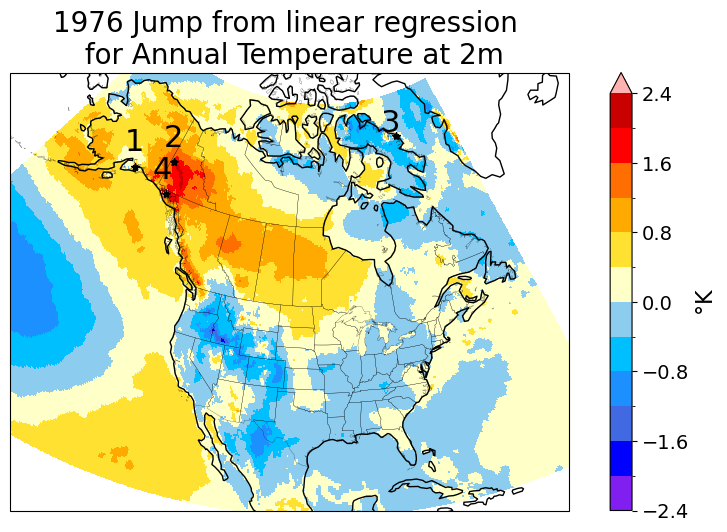

In [75]:
cmap=cmaps.ncl_default
proj=ccrs.LambertConformal(265,25)

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10,6),subplot_kw={'projection':proj})
plt.subplots_adjust(bottom=0.15, right=0.95)

clevs = np.arange(-2.4,2.8,0.4)
cc=jump.plot.pcolormesh(ax=ax,cmap=cmap,levels=clevs,transform=ccrs.PlateCarree(),\
                        add_colorbar=False)
for ip in range(0,len(ptlon)):
  ax.plot(ptlon[ip]+360,ptlat[ip],marker='*',color='k',transform=ccrs.PlateCarree())
  ax.text(ptlon[ip]-360-5,ptlat[ip]+1.,f'{ip+1}',color='k',size=22,transform=ccrs.PlateCarree())
ax.set_extent([-140+360, -60, 15, 75], ccrs.Geodetic())
ax.add_feature(state_borders,zorder=100,edgecolor='k',linewidth=0.15)
ax.coastlines()
cbar=fig.colorbar(cc)
cbar.ax.tick_params(labelsize=14)  
cbar.set_label(label=units,fontsize=16)
ax.set_title(f'{yeari} Jump from linear regression \n for Annual Temperature at 2m',fontsize=20)

<>:11: SyntaxWarning: invalid escape sequence '\d'
<>:11: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_483484/708461867.py:11: SyntaxWarning: invalid escape sequence '\d'
  ax1.set_ylabel(f'air.2m ($\degree$K)', color='k',fontsize=16)


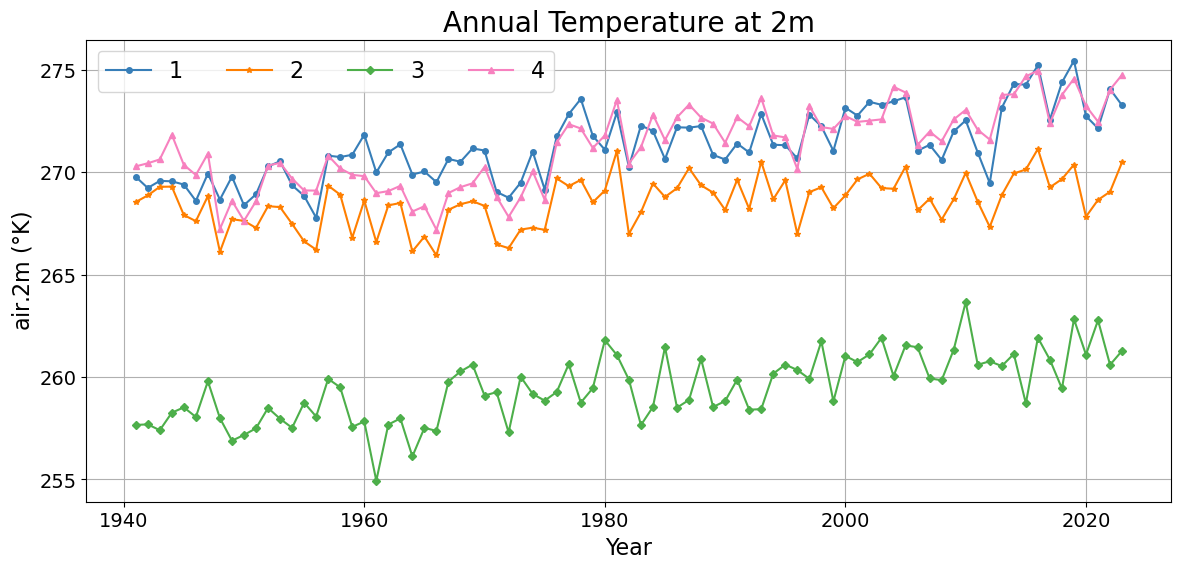

In [76]:
colors = ['#377eb8','#ff7f00', '#4daf4a','#f781bf']
markers = ['o','*','D','^']
Tlabels=['1','2','3','4']
#####
fig, ax1 = plt.subplots(figsize=(14,6))
#ax2 = ax1.twinx()
for ij in range(len(ptlon)): 
  ax1.plot(np.arange(yearb,yeare+1,1),ann_air.sel(lon=ptlon[ij],lat=ptlat[ij]),\
           color=colors[ij],marker=markers[ij],markersize=4,label=f'{Tlabels[ij]}')

ax1.set_ylabel(f'air.2m ($\degree$K)', color='k',fontsize=16)
ax1.tick_params(axis='x', labelcolor='k',labelsize=14)
ax1.tick_params(axis='y', labelcolor='k',labelsize=14)
ax1.set_xlabel('Year',fontsize=16)
ax1.grid()
ax1.legend(fontsize=16,ncol=4)
ax1.set_title('Annual Temperature at 2m',fontsize=20)
outfile=f'PLOTS/air.2m_timeseries.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

# Hottest Maximum Temperature

In [77]:

year=np.arange(yearb,yeare+1,1)
files=[f'{datadir}/Hottest_Day.era5.{iyear}.nc' for iyear in year]
dstmax = xr.open_mfdataset(files,combine='nested', concat_dim='year')
dstmax = dstmax.sortby('lat')
dstmax = dstmax.sel(lon=slice(lon_min,lon_max),lat=slice(lat_min,lat_max))
dstmax =dstmax.load()
dstmax['year'] = year.astype('int64')
units='$\degree$K'


<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:8: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_483484/2111057089.py:8: SyntaxWarning: invalid escape sequence '\d'
  units='$\degree$K'


In [78]:
trend_b = trend_dim(dstmax['hottest_tmax'].sel(year=time_b),'year')
trend_a = trend_dim(dstmax['hottest_tmax'].sel(year=time_a),'year')

deg0_b = trend_b['polyfit_coefficients'].sel(degree=0)
deg1_b = trend_b['polyfit_coefficients'].sel(degree=1) 
deg0_a = trend_a['polyfit_coefficients'].sel(degree=0)
deg1_a = trend_a['polyfit_coefficients'].sel(degree=1)

jump = (deg1_a * time_a[0].data + deg0_a) - (deg1_b * time_b[-1].data + deg0_b)

Text(0.5, 1.0, '1976 Jump from linear regression \n for Hottest Maximum Temperature')

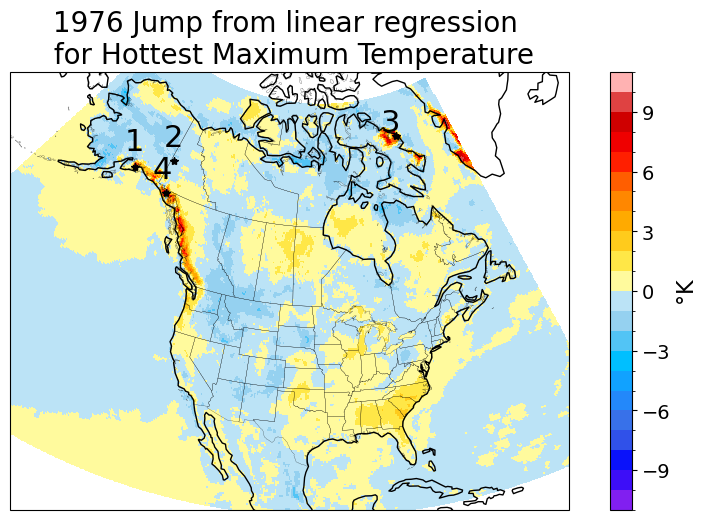

In [79]:
cmap=cmaps.ncl_default
proj=ccrs.LambertConformal(265,25)

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10,6),subplot_kw={'projection':proj})
plt.subplots_adjust(bottom=0.15, right=0.95)

clevs = np.arange(-11.,12.,1.)
cc=jump.plot.pcolormesh(ax=ax,cmap=cmap,levels=clevs,transform=ccrs.PlateCarree(),\
                        add_colorbar=False)
for ip in range(0,len(ptlon)):
  ax.plot(ptlon[ip]+360,ptlat[ip],marker='*',color='k',transform=ccrs.PlateCarree())
  ax.text(ptlon[ip]-360-5,ptlat[ip]+1.,f'{ip+1}',color='k',size=22,transform=ccrs.PlateCarree())
ax.set_extent([-140+360, -60, 15, 75], ccrs.Geodetic())
ax.add_feature(state_borders,zorder=100,edgecolor='k',linewidth=0.15)
ax.coastlines()
cbar=fig.colorbar(cc)
cbar.ax.tick_params(labelsize=14)  
cbar.set_label(label=units,fontsize=16)
ax.set_title(f'{yeari} Jump from linear regression \n for Hottest Maximum Temperature',fontsize=20)

<>:11: SyntaxWarning: invalid escape sequence '\d'
<>:11: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_483484/1429559491.py:11: SyntaxWarning: invalid escape sequence '\d'
  ax1.set_ylabel(f'Tmax ($\degree$K)', color='k',fontsize=16)


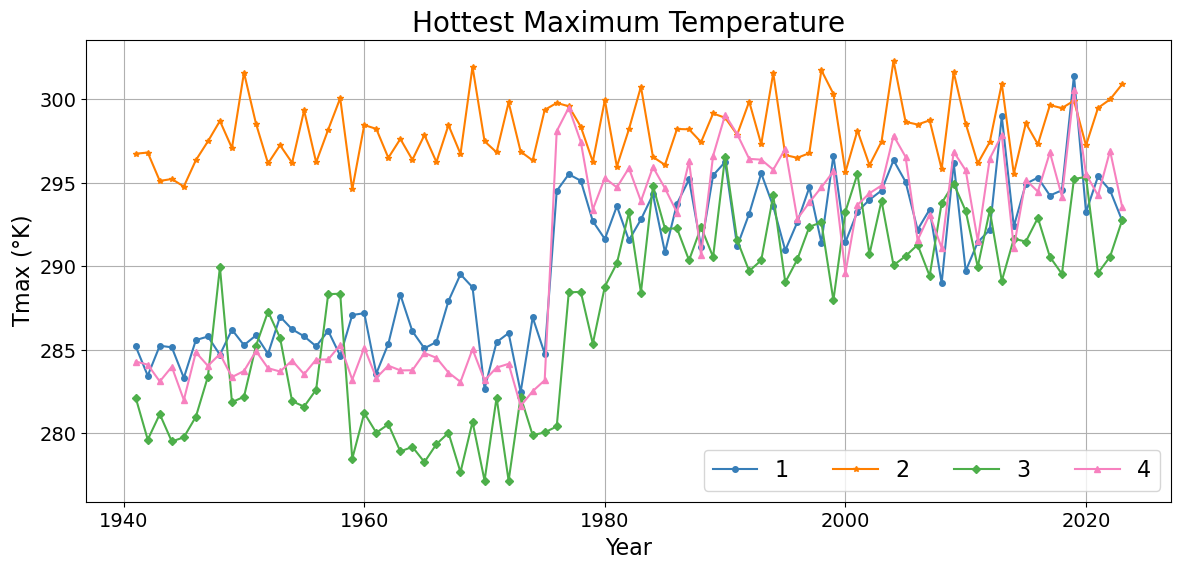

In [80]:
colors = ['#377eb8','#ff7f00', '#4daf4a','#f781bf']
markers = ['o','*','D','^']
Tlabels=['1','2','3','4']
#####
fig, ax1 = plt.subplots(figsize=(14,6))
#ax2 = ax1.twinx()
for ij in range(len(ptlon)): 
  ax1.plot(np.arange(yearb,yeare+1,1),dstmax['hottest_tmax'].sel(lon=ptlon[ij],lat=ptlat[ij]),\
           color=colors[ij],marker=markers[ij],markersize=4,label=f'{Tlabels[ij]}')

ax1.set_ylabel(f'Tmax ($\degree$K)', color='k',fontsize=16)
ax1.tick_params(axis='x', labelcolor='k',labelsize=14)
ax1.tick_params(axis='y', labelcolor='k',labelsize=14)
ax1.set_xlabel('Year',fontsize=16)
ax1.grid()
ax1.legend(fontsize=16,ncol=4)
ax1.set_title('Hottest Maximum Temperature',fontsize=20)
outfile=f'PLOTS/tmax.2m_timeseries.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

# Coldest Minimum Temperature

In [81]:

year=np.arange(yearb,yeare+1,1)
files=[f'{datadir}/Coldest_Day.era5.{iyear}.nc' for iyear in year]
dstmin = xr.open_mfdataset(files,combine='nested', concat_dim='year')
dstmin = dstmin.sortby('lat')
dstmin = dstmin.sel(lon=slice(lon_min,lon_max),lat=slice(lat_min,lat_max))
dstmin =dstmin.load()
dstmin['year'] = year.astype('int64')
units='$\degree$K'

<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:8: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_483484/2887465874.py:8: SyntaxWarning: invalid escape sequence '\d'
  units='$\degree$K'


In [82]:
trend_b = trend_dim(dstmin['coldest_tmin'].sel(year=time_b),'year')
trend_a = trend_dim(dstmin['coldest_tmin'].sel(year=time_a),'year')

deg0_b = trend_b['polyfit_coefficients'].sel(degree=0)
deg1_b = trend_b['polyfit_coefficients'].sel(degree=1) 
deg0_a = trend_a['polyfit_coefficients'].sel(degree=0)
deg1_a = trend_a['polyfit_coefficients'].sel(degree=1)

jump = (deg1_a * time_a[0].data + deg0_a) - (deg1_b * time_b[-1].data + deg0_b)

Text(0.5, 1.0, '1976 Jump from linear regression \n for Coldest Minimum Temperature')

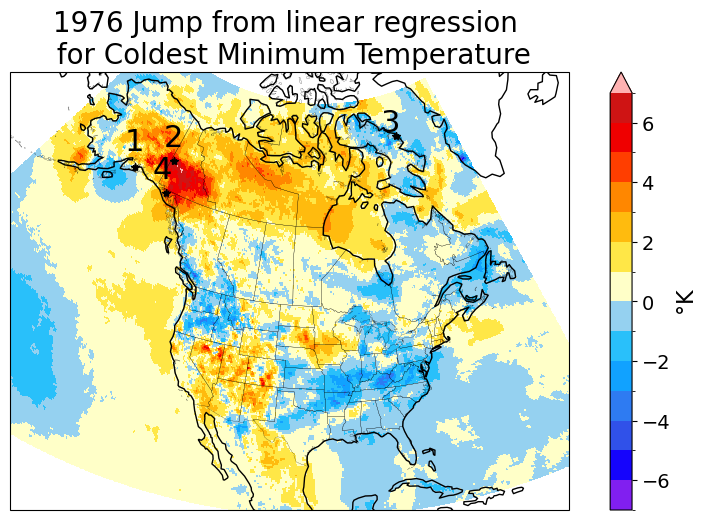

In [83]:
cmap=cmaps.ncl_default
proj=ccrs.LambertConformal(265,25)

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10,6),subplot_kw={'projection':proj})
plt.subplots_adjust(bottom=0.15, right=0.95)

clevs = np.arange(-7.,8,1)
cc=jump.plot.pcolormesh(ax=ax,cmap=cmap,levels=clevs,transform=ccrs.PlateCarree(),\
                        add_colorbar=False)
for ip in range(0,len(ptlon)):
  ax.plot(ptlon[ip]+360,ptlat[ip],marker='*',color='k',transform=ccrs.PlateCarree())
  ax.text(ptlon[ip]-360-5,ptlat[ip]+1.,f'{ip+1}',color='k',size=22,transform=ccrs.PlateCarree())
ax.set_extent([-140+360, -60, 15, 75], ccrs.Geodetic())
ax.add_feature(state_borders,zorder=100,edgecolor='k',linewidth=0.15)
ax.coastlines()
cbar=fig.colorbar(cc)
cbar.ax.tick_params(labelsize=14)  
cbar.set_label(label=units,fontsize=16)
ax.set_title(f'{yeari} Jump from linear regression \n for Coldest Minimum Temperature',fontsize=20)

<>:11: SyntaxWarning: invalid escape sequence '\d'
<>:11: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_483484/673797864.py:11: SyntaxWarning: invalid escape sequence '\d'
  ax1.set_ylabel(f'Tmin ($\degree$K)', color='k',fontsize=16)


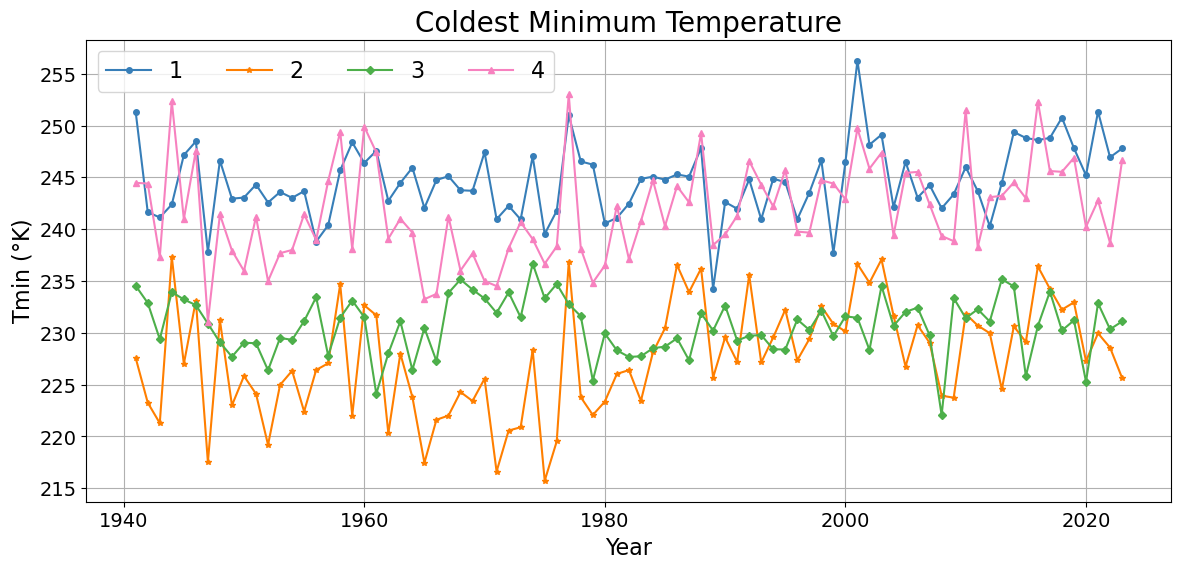

In [84]:
colors = ['#377eb8','#ff7f00', '#4daf4a','#f781bf']
markers = ['o','*','D','^']
Tlabels=['1','2','3','4']
#####
fig, ax1 = plt.subplots(figsize=(14,6))
#ax2 = ax1.twinx()
for ij in range(len(ptlon)): 
  ax1.plot(np.arange(yearb,yeare+1,1),dstmin['coldest_tmin'].sel(lon=ptlon[ij],lat=ptlat[ij]),\
           color=colors[ij],marker=markers[ij],markersize=4,label=f'{Tlabels[ij]}')

ax1.set_ylabel(f'Tmin ($\degree$K)', color='k',fontsize=16)
ax1.tick_params(axis='x', labelcolor='k',labelsize=14)
ax1.tick_params(axis='y', labelcolor='k',labelsize=14)
ax1.set_xlabel('Year',fontsize=16)
ax1.grid()
ax1.legend(fontsize=16,ncol=4)
ax1.set_title('Coldest Minimum Temperature',fontsize=20)
outfile=f'PLOTS/tmin.2m_timeseries.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')